# Dependencies

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath('../'))
from counterfactual_tpp import sample_counterfactual, superposition, combine, check_monotonicity, distance, covariance
from sampling_utils import homogenous_poisson, thinning, thinning_T

In [2]:
def normal(x, mean, sd, amp):  
    return amp * (1/(sd * (np.sqrt(2*np.pi)))) * np.exp(-0.5*((x-mean)/sd)**2)

def normal_1(x):  # original intensity
    mean = [5, 10, 15]
    sd = 1
    return normal(x, mean[0], sd, 1) + normal(x, mean[1], sd, 1) + normal(x, mean[2], sd, 1)

def  normal_2(x):  # intervened intensity
    mean = [6, 11, 16]
    sd = 1
    return normal(x, mean[0], sd, 1.5) + normal(x, mean[1], sd, 1.5) + normal(x, mean[2], sd, 1.5)

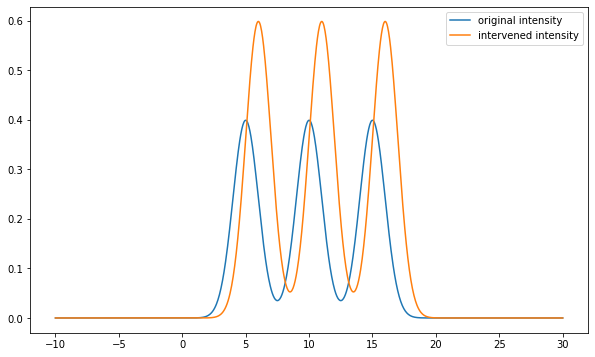

In [3]:
# plotting the intensities first
plt.figure(figsize=(10, 6))
x = np.linspace(-10, 30, 1000)
plt.plot(x, normal_1(x), label='original intensity')
plt.plot(x, normal_2(x), label='intervened intensity')
plt.legend()
# plt.savefig('../intensities.png', format = 'png', dpi = 900)
plt.show()

# Sampling From Lambda_max

In [6]:
# sampling from lambda_max, statring with zero
lambda_max = 0.6
T = 25
sample, indicators = thinning_T(0, intensity=normal_1, lambda_max=lambda_max, max_number_of_samples= 200, T=T)
accepted = [sample[i] for i in range(len(sample)) if indicators[i] == True]
lambdas = normal_1(np.asarray(sample))
sample = np.asarray(sample)
print('All events:\n', sample)
print('{} out of {} samples accepted.'.format(len(accepted), len(sample)))
print('accepted events:\n', accepted)
print('indicators:\n', indicators)

All events:
 [ 2.1784423   2.56162523  3.63325456  4.07261548  5.40068028  7.33914279
  9.41220827 10.08190666 10.40971627 10.42033711 10.9286481  10.99170896
 12.73435429 12.88664343 13.18496586 14.63388778 16.62825092 19.70093319
 21.0701447  21.40323593 21.47519474 21.70760766 23.42527675]
7 out of 23 samples accepted.
accepted events:
 [3.6332545584153113, 5.400680280709712, 9.412208267055469, 10.081906664538296, 10.409716266969962, 10.928648095354943, 16.628250918711746]
indicators:
 [False, False, True, False, True, False, True, True, True, False, True, False, False, False, False, False, True, False, False, False, False, False, False]


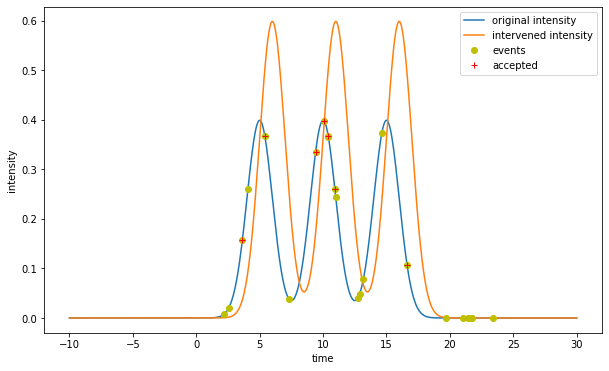

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(x, normal_1(x), label='original intensity')
plt.plot(x, normal_2(x), label='intervened intensity')
plt.plot(sample,lambdas, 'oy', label = 'events')
plt.plot(sample[indicators],lambdas[indicators], 'r+', label = 'accepted')
plt.xlabel('time')
plt.ylabel('intensity')
plt.legend()
# plt.savefig('../sample_max.png', format = 'png', dpi = 900)

In [8]:
counterfactuals, counterfactual_indicators = sample_counterfactual(sample, lambdas, lambda_max, indicators, normal_2)
print('counterfactuals:\n', counterfactuals)
print(len(counterfactuals))

counterfactuals:
 [5.400680280709712, 9.412208267055469, 10.081906664538296, 10.409716266969962, 10.420337110073211, 10.928648095354943, 10.991708959112989, 16.628250918711746]
8


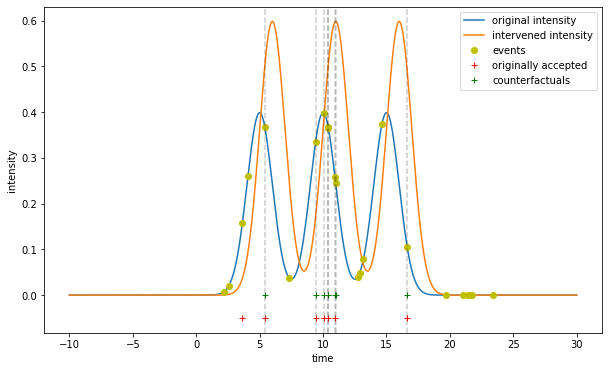

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(x, normal_1(x), label='original intensity')
plt.plot(x, normal_2(x), label='intervened intensity')
plt.plot(sample,lambdas, 'oy', label = 'events')
plt.plot(accepted,np.full(len(accepted), -0.05), 'r+', label = 'originally accepted')
plt.plot(counterfactuals,np.full(len(counterfactuals), 0), 'g+', label = 'counterfactuals')
for xc in counterfactuals:
    plt.axvline(x=xc, color = 'k', ls = '--', alpha = 0.2)
plt.xlabel('time')
plt.ylabel('intensity')
plt.legend()
# plt.savefig('../counter_max.png', format = 'png', dpi = 900)

As we can see, all of the accepted events that have higher intensity, are also accepted in the counter factual.

In [10]:
check_monotonicity(sample, counterfactuals, normal_1, normal_2, accepted) 

MONOTONIC


In [11]:
print('Distanse: {}'.format(distance(np.array(accepted), np.array(counterfactuals), T)))

Distanse: 20.795373592544912


In [13]:
cov = covariance(sample, indicators, counterfactual_indicators, T, normal_1, normal_2, lambda_max)
print('Covariance: {}'.format(np.mean(cov)))

Covariance: -2.9860199999999986


# Real-World Scenario

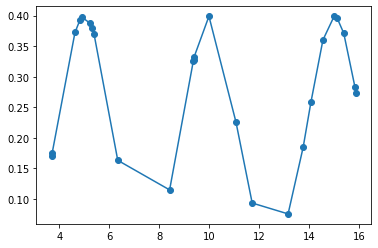

In [14]:
h_observed, lambda_observed, h_rejected, lambda_bar_rejected = superposition(lambda_max, normal_1, 12, 25)
plt.plot(h_observed, lambda_observed, '-o')
# plt.savefig('../observed.png', format = 'png', dpi = 900)

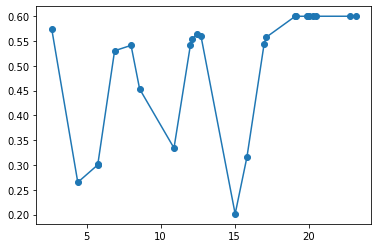

In [15]:
plt.plot(h_rejected, lambda_bar_rejected, '-o')
# plt.savefig('../superposition.png', format = 'png', dpi = 900)

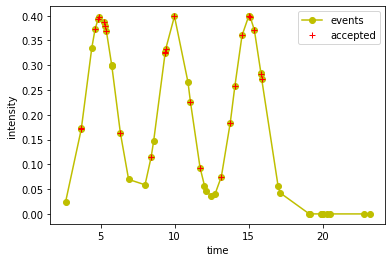

In [16]:
sample_rc, lambdas_rc, indicators_rc = combine(h_observed, lambda_observed, h_rejected, normal_1)
plt.plot(sample_rc,lambdas_rc, '-oy', label = 'events')
plt.plot(sample_rc[indicators_rc],lambdas_rc[indicators_rc], 'r+', label = 'accepted')
plt.xlabel('time')
plt.ylabel('intensity')
plt.legend()
# plt.savefig('../combine.png', format = 'png', dpi = 900)

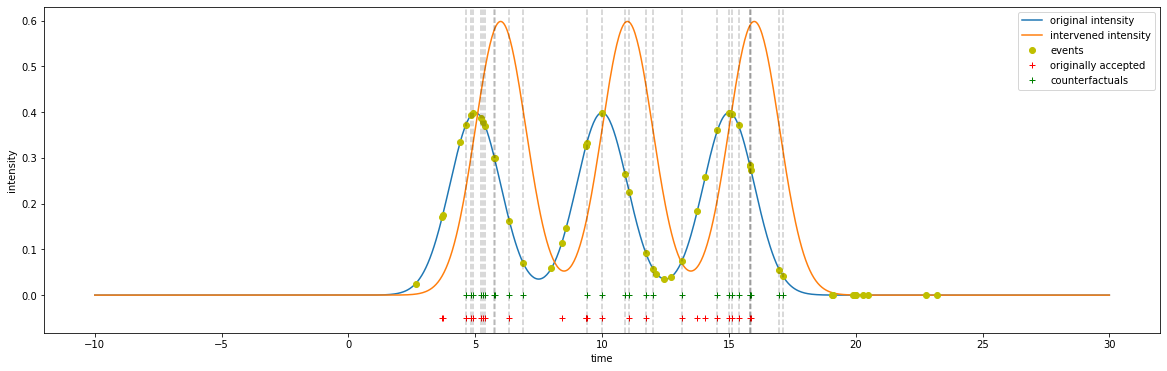

In [17]:
counterfactuals_rc, counterfactual_indicators_rc = sample_counterfactual(sample_rc, lambdas_rc, lambda_max, indicators_rc, normal_2)
plt.figure(figsize=(20, 6))
plt.plot(x, normal_1(x), label='original intensity')
plt.plot(x, normal_2(x), label='intervened intensity')
plt.plot(sample_rc,lambdas_rc, 'oy', label = 'events')
# plt.plot(sample_rc[indicators_rc],lambdas_rc[indicators_rc], 'r+', label = 'accepted')
# plt.plot(counterfactuals_rc, lambdas_rc[counterfactual_indicators_rc], 'g^', label = 'counterfactuals')
plt.plot(sample_rc[indicators_rc],np.full(len(sample_rc[indicators_rc]), -0.05), 'r+', label = 'originally accepted')
plt.plot(counterfactuals_rc,np.full(len(counterfactuals_rc), 0), 'g+', label = 'counterfactuals')
for xc in counterfactuals_rc:
    plt.axvline(x=xc, color = 'k', ls = '--', alpha = 0.2)
plt.xlabel('time')
plt.ylabel('intensity')
plt.legend()
# plt.savefig('../counter_real.png', format = 'png', dpi = 900)

In [18]:
check_monotonicity(sample_rc, counterfactuals_rc, normal_1, normal_2, h_observed)

MONOTONIC


In [19]:
print('Distanse: {}'.format(distance(np.array(sample_rc[indicators_rc]), np.array(counterfactuals_rc), 2 * 12)))

Distanse: 21.682223695884474


In [20]:
cov = covariance(sample_rc, indicators_rc, counterfactual_indicators_rc, T, normal_1, normal_2, lambda_max)
print('Covariance: {}'.format(np.mean(cov)))

Covariance: -4.482579999999999
